In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
import time
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
select_device(0)

In [3]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, 
                                                                     hidden_units=(676,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 2e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 3e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [4]:
start = time.time()
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)
print(time.time()-start)

2020-06-11 10:10:15,731 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-06-11 10:10:21,022 - root - INFO: steps 5000, episodic_return_test -180.00(18.97)
2020-06-11 10:10:25,965 - root - INFO: steps 10000, episodic_return_test -160.40(25.05)
2020-06-11 10:10:30,605 - root - INFO: steps 15000, episodic_return_test -82.60(30.32)
2020-06-11 10:10:35,057 - root - INFO: steps 20000, episodic_return_test -7.20(1.09)
2020-06-11 10:10:39,506 - root - INFO: steps 25000, episodic_return_test -25.70(18.40)
2020-06-11 10:10:44,000 - root - INFO: steps 30000, episodic_return_test -5.40(0.70)


32.061529874801636


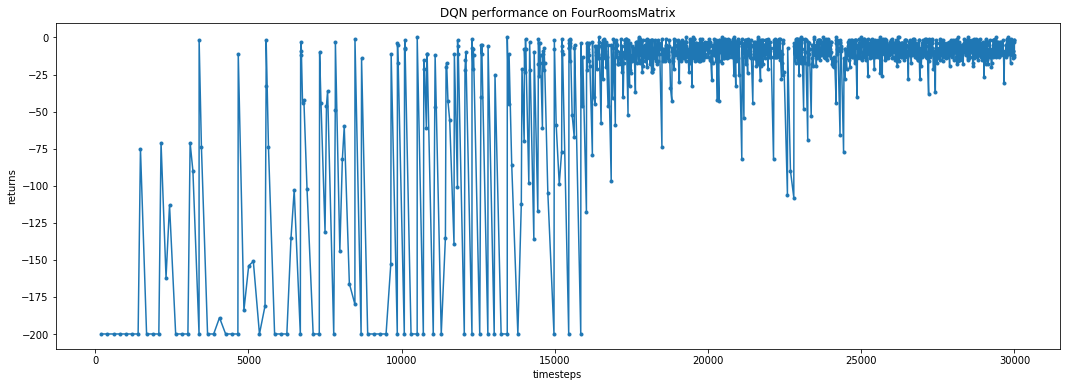

(Text(0.5, 1.0, 'DQN performance on FourRoomsMatrix'), None)

In [42]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [6]:
print(agent.network)

VanillaNet(
  (fc_head): Linear(in_features=676, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=169, out_features=676, bias=True)
    )
  )
)


In [49]:
weights = list(agent.network.parameters())[2]
biases = list(agent.network.parameters())[3]

In [50]:
weights = weights.detach().cpu().numpy().flatten()
biases = biases.detach().cpu().numpy()

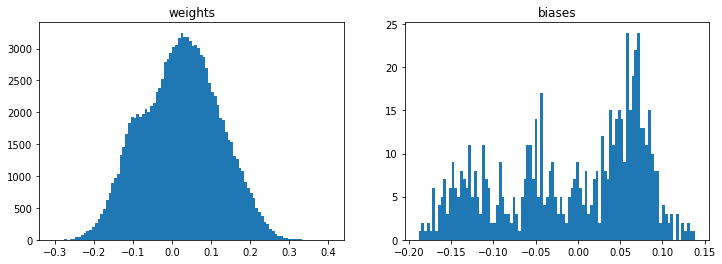

(Text(0.5, 1.0, 'biases'), None)

In [51]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.hist(weights, bins=100)
plt.title('weights'), plt.subplot(122)
plt.hist(biases, bins=100)
plt.title('biases'), plt.show()

In [52]:
print(weights.shape, biases.shape)
# random shuffling
# np.random.shuffle(biases)
# np.random.shuffle(weights)
weights = np.reshape(weights, (676, 169))
print(weights.shape, biases.shape)

(114244,) (676,)
(676, 169) (676,)


In [53]:
"""
1. Use these new weights to initialize a network.
2. Fix these weights and fine tune the following layer.
3. See learning performance and save plots.
""" 
# Step 1
import collections
od_weights = collections.OrderedDict()
od_weights['layers.0.weight'] = torch.Tensor(weights)
od_weights['layers.0.bias'] = torch.Tensor(biases)

import pickle
pickle.dump( od_weights, open( "storage/layer1_noshuffle.p", "wb" ) )
# od_weights = pickle.load( open( "save.p", "rb" ) )

# agent.network.load_state_dict(od_weights)

In [30]:
import pickle
# pickle.dump( od_weights, open( "tmp.p", "wb" ) )
od_weights = pickle.load( open( "storage/layer1_noshuffle.p", "rb" ) )

In [31]:
# Step 2
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=1)
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        if(ref == -1):
            print(agent.network.load_state_dict(od_weights, strict=False))
        else:
            print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [32]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [33]:
r_noshuffle = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=-1)

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=[])


2020-06-11 10:21:52,500 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2020-06-11 10:21:58,851 - root - INFO: steps 5000, episodic_return_test -121.10(30.56)
2020-06-11 10:22:04,760 - root - INFO: steps 10000, episodic_return_test -6.30(0.75)
2020-06-11 10:22:11,104 - root - INFO: steps 15000, episodic_return_test -122.50(30.03)
2020-06-11 10:22:17,138 - root - INFO: steps 20000, episodic_return_test -46.10(24.36)
2020-06-11 10:22:23,049 - root - INFO: steps 25000, episodic_return_test -3.80(0.60)
2020-06-11 10:22:28,967 - root - INFO: steps 30000, episodic_return_test -6.00(1.19)
2020-06-11 10:22:34,881 - root - INFO: steps 35000, episodic_return_test -5.80(1.28)
2020-06-11 10:22:40,808 - root - INFO: steps 40000, episodic_return_test -6.00(1.44)
2020-06-11 10:22:46,690 - root - INFO: steps 45000, episodic_return_test -6.50(1.23)
2020-06-11 10:22:52,481 - root - INFO: steps 50000, episodic_return_test -5.70(1.12)


IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=[])


2020-06-11 10:22:53,184 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2020-06-11 10:22:59,268 - root - INFO: steps 5000, episodic_return_test -101.50(31.15)
2020-06-11 10:23:04,972 - root - INFO: steps 10000, episodic_return_test -7.60(0.97)
2020-06-11 10:23:10,735 - root - INFO: steps 15000, episodic_return_test -6.40(1.08)
2020-06-11 10:23:16,909 - root - INFO: steps 20000, episodic_return_test -123.10(29.79)
2020-06-11 10:23:22,619 - root - INFO: steps 25000, episodic_return_test -6.00(1.29)
2020-06-11 10:23:28,335 - root - INFO: steps 30000, episodic_return_test -7.40(1.23)
2020-06-11 10:23:34,029 - root - INFO: steps 35000, episodic_return_test -6.40(1.04)
2020-06-11 10:23:39,660 - root - INFO: steps 40000, episodic_return_test -4.90(1.15)
2020-06-11 10:23:45,449 - root - INFO: steps 45000, episodic_return_test -6.20(1.19)
2020-06-11 10:23:51,174 - root - INFO: steps 50000, episodic_return_test -7.30(1.13)


IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=[])


2020-06-11 10:23:51,942 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2020-06-11 10:23:58,191 - root - INFO: steps 5000, episodic_return_test -84.30(29.88)
2020-06-11 10:24:04,205 - root - INFO: steps 10000, episodic_return_test -6.90(0.97)
2020-06-11 10:24:10,503 - root - INFO: steps 15000, episodic_return_test -101.90(31.03)
2020-06-11 10:24:16,822 - root - INFO: steps 20000, episodic_return_test -103.90(30.39)
2020-06-11 10:24:22,745 - root - INFO: steps 25000, episodic_return_test -6.50(1.20)
2020-06-11 10:24:28,693 - root - INFO: steps 30000, episodic_return_test -6.00(1.17)
2020-06-11 10:24:34,584 - root - INFO: steps 35000, episodic_return_test -7.10(1.11)
2020-06-11 10:24:40,510 - root - INFO: steps 40000, episodic_return_test -5.60(1.15)
2020-06-11 10:24:46,384 - root - INFO: steps 45000, episodic_return_test -6.30(1.27)
2020-06-11 10:24:52,227 - root - INFO: steps 50000, episodic_return_test -4.80(1.23)


In [28]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 500
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

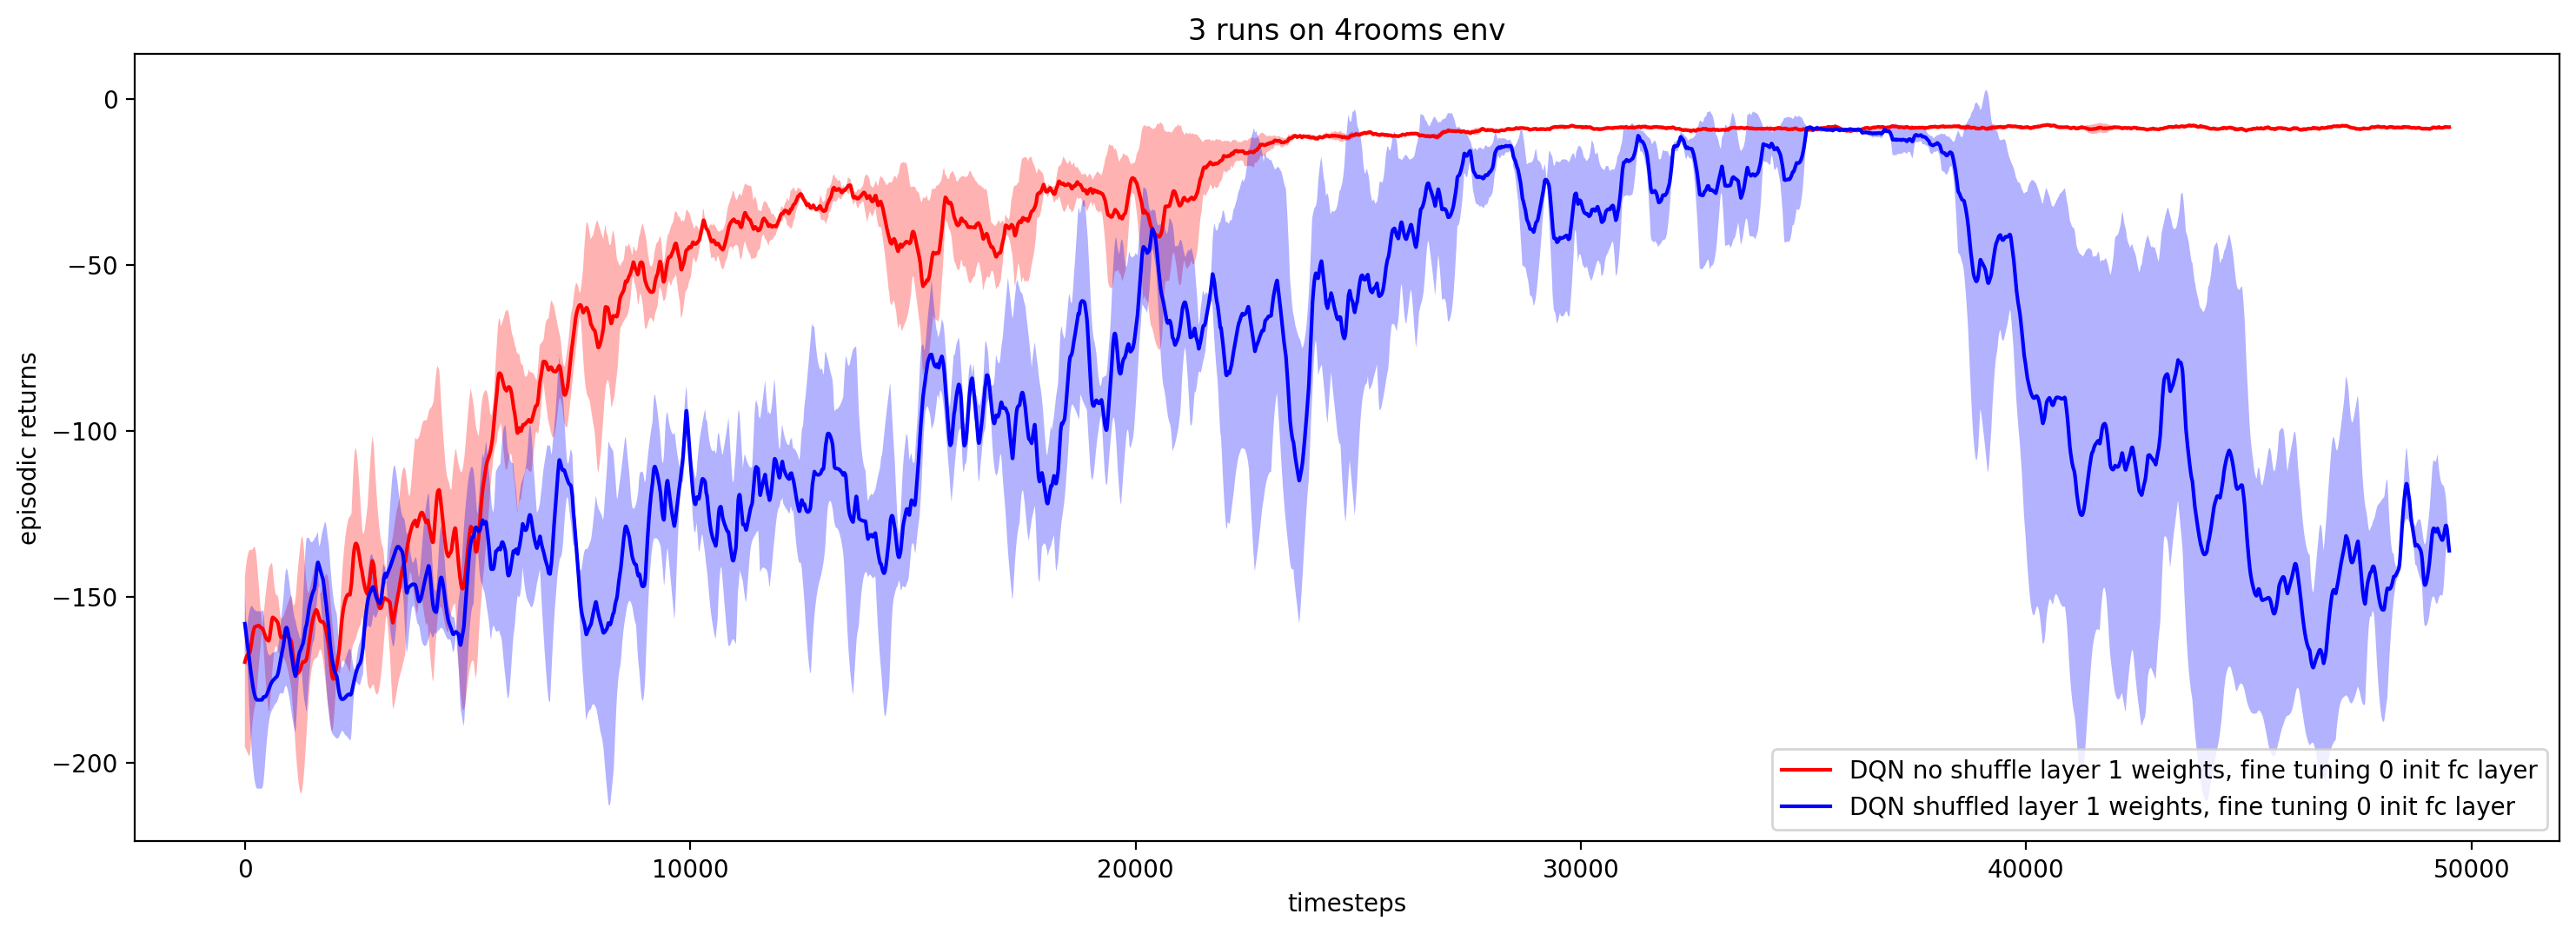

In [55]:
rewards_dict = {
               'DQN no shuffle layer 1 weights, fine tuning 0 init fc layer': r_noshuffle,
               'DQN shuffled layer 1 weights, fine tuning 0 init fc layer': r_shuffle
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='3 runs on 4rooms env')

In [54]:
import pickle
pickle.dump( rewards_dict, open( "storage/9-plots.p", "wb" ) )
rewards_dict = pickle.load( open( "storage/9-plots.p", "rb" ) )

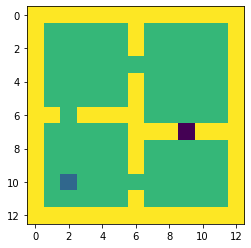

In [39]:
from deep_rl.component.fourrooms import * # CHECK
env = FourRoomsMatrix()
env.reset()
env.reset()
plt.imshow(env.render())